In [1]:
import sys
import pandas as pd

from detector_map import smurf_chan_to_realized_freq, all_smurf_chan_to_realized_freq, vna_freq_to_muxpad, \
    smurf_to_mux, mux_band_to_mux_posn, get_pad_to_wafer, smurf_to_detector
import glob
from vna_func import *
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 20)
sys.path.append("/home/kaiwenz/opt_eff_calculation/modules/")  # path contains python_file.py
from read_iv import read_psat
from peak_finder_v2 import get_peaks_v2
import read_iv as iv

Populating the interactive namespace from numpy and matplotlib


In [41]:
import sys
sys.path.append('/home/kaiwenz/.local/lib/python3.6/site-packages')
%pylab inline
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
from scipy.interpolate import interp1d
import scipy.optimize as optimize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import math

Populating the interactive namespace from numpy and matplotlib


In [12]:
highband="S"
shift=10
waferfile="metadata/copper_map_corrected.csv"
design_file="metadata/umux_32_map.pkl"
bands=np.arange(8)
dict_thru={"N":[7],"S":[]} 
dark_bias_lines=[4,5,6,7,8,9,10,11] #If certain sides are covered
smurf_tune='/data/legacy/smurfsrv/tune/1632247315_tune.npy'
band2posn=pd.DataFrame({'mux_band':np.array([1,9,4,2,0,6,8,10,12,13,11,5,3,3,5,11,13,12,10,8,6,0,2,4,9,7,1]),
                       'mux_posn':np.concatenate((np.array([0]),np.arange(2,28)))})

In [5]:
dir_N='/data/vna/20210907_michi_Mv6_Mv7_SPB14/cold_device/RF1/'
dir_S='/data/vna/20210907_michi_Mv6_Mv7_SPB14/cold_device/RF4/'
N_band=glob.glob(dir_N+'*.S2P')
N_band.sort()
S_band=glob.glob(dir_S+'*.S2P')
S_band.sort()
N_files=N_band[3:-1]
S_files=S_band[2:]

In [13]:
def get_peaks_from_vna(vna_files):
    f,r,i=read_vna_data_array(vna_files)
    s21_corrected=correct_trend(f,r,i,avg_over=1000) 
    f0s, resonance_s21,low,high= get_peaks_v2(f,s21_corrected,f_delta=1e5,det_num=1000,baseline=0.1) 
    return f0s

def assign_index_use_vna(S_files,N_files,highband,dict_thru,shift=10):
    assert ((highband=="N") | (highband=="S"))
    south_res=get_peaks_from_vna(S_files)
    print("South Side fit completed.")
    north_res=get_peaks_from_vna(N_files)
    print("North Side fit completed.")
    south_res=south_res/1e6+2000*(highband=="S")
    north_res=north_res/1e6+2000*(highband=="N")
    band_array=[]
    index_array=[]
    freq_array=[]
    for band in np.arange(8):
        if (((highband=="S") & (band>3)) | ((highband=="N") & (band<=3))): 
            bandfreq=south_res[(south_res>band*500+4000+shift)& (south_res<band*500+4500+shift)]
        else: bandfreq=north_res[(north_res>band*500+4000+shift)& (north_res<band*500+4500+shift)]
        print("Band",band," has ",len(bandfreq)," resonators.")
        mux_band,mux_index,miss=assign_freq_index(band, bandfreq,dict_thru,highband)
        band_array=np.concatenate((band_array,mux_band))
        index_array=np.concatenate((index_array,mux_index))
        freq_array=np.concatenate((freq_array,bandfreq))
    return pd.DataFrame({"Band":band_array,"Index":index_array,"UFM Frequency": freq_array})

In [14]:
def assign_index_use_tune(smurf_tune, bands=np.arange(8), dict_thru={"N":[],"S":[]}, highband="S"):  
    band_array=[]
    index_array=[]
    chan_assign=read_smurf_channels(smurf_tune)
    chan_assign=chan_assign.loc[chan_assign['channel']!=-1]
    #print("Tune file has ",len(chan_assign)," resonators\n")
    for band in bands:
        df_band=chan_assign.loc[chan_assign['band']==band]
        #print("Band",band," has ",len(df_band)," resonators.")
        mux_band,mux_index,miss=assign_freq_index(band, df_band["frequency"],dict_thru,highband)
        band_array=np.concatenate((band_array,mux_band))
        index_array=np.concatenate((index_array,mux_index))
    return pd.DataFrame({"Band":band_array,"Index":index_array,"UFM Frequency": chan_assign["frequency"]})

In [15]:
def assign_freq_index(band, freqlist, dict_thru,highband):
    if (((highband=="S") & (band>3)) | ((highband=="N") & (band<=3))): 
        missing_chip=dict_thru["S"]
    else:missing_chip=dict_thru["N"]
    counts=len(freqlist)
    mux_band=np.zeros(counts)
    mux_index=np.zeros(counts)
    init_band=math.floor((band%4)*3.5)
    miss=(3.5*66)-counts
    offset=0
    if band%2==1:offset=33
    for i in np.arange(4):
        init_index=0
        if (init_band+i) in missing_chip:
            if missing_chip in [3,10]:
                miss-=33; offset+=33;
            else: miss-=66; offset+=66;
            continue
        start=max(0,66*i-offset)
        end=min(counts,(i+1)*66-offset)
        mux_band[start:end]+=i+init_band
        if (band%2==1) & (i==0):
            mux_index[start:end]=np.arange(33,33+end-start)
        else:mux_index[start:end]=np.arange(end-start)
    print("Band %i misses %i resonators (%.2f percent)\n"
          %(band,miss,100*miss/(miss+len(freqlist))))
    return mux_band,mux_index,miss

In [21]:
def automated_map(S_files,N_files,highband,shift,dict_thru,smurf_tune,dark_bias_lines, design_file, band2posn, waferfile,threshold=0.1):
    
    chan_assign=read_smurf_channels(smurf_tune)

    if ((S_files!=None) & (N_files!= None)):
        df_vna=assign_index_use_vna(S_files,N_files,highband,dict_thru,shift=10)
    else:
        """
        This is not finished
        """
        pass
    
    chan_assign=chan_assign[["band","channel","frequency"]]
    chan_assign=chan_assign.rename(columns={"band":"smurf_band","channel":"smurf_chan","frequency":"smurf_freq"}).reset_index(drop=True)
    
    df_low=df_vna.loc[df_vna["UFM Frequency"]<6e3].drop_duplicates(subset=['Band','Index']).reset_index()
    df_high=df_vna.loc[(df_vna["UFM Frequency"]>6e3) & (df_vna["UFM Frequency"]<8e3)].drop_duplicates(subset=['Band','Index']).reset_index()
    
    df_pad_low=vna_freq_to_muxpad(df_low,design_file)
    df_pad_high=vna_freq_to_muxpad(df_high,design_file)
    pad=pd.concat([df_pad_low,df_pad_high]).reset_index()
    
    smurf2mux=smurf_to_mux(chan_assign,pad,threshold)
    smurf2padloc=mux_band_to_mux_posn(smurf2mux,band2posn)
    wafer_info=get_pad_to_wafer(waferfile,dark_bias_lines=dark_bias_lines)
    smurf2det=smurf_to_detector(smurf2padloc,wafer_info)
    
    return smurf2det



In [23]:
automated_map(S_files,N_files,highband,shift,dict_thru,smurf_tune,dark_bias_lines, design_file, band2posn, waferfile)

South Side fit completed.
North Side fit completed.
Band 0  has  230  resonators.
Band 0 misses 1 resonators (0.43 percent)

Band 1  has  233  resonators.
Band 1 misses -2 resonators (-0.87 percent)

Band 2  has  165  resonators.
Band 2 misses 0 resonators (0.00 percent)

Band 3  has  230  resonators.
Band 3 misses 1 resonators (0.43 percent)

Band 4  has  229  resonators.
Band 4 misses 2 resonators (0.87 percent)

Band 5  has  229  resonators.
Band 5 misses 2 resonators (0.87 percent)

Band 6  has  231  resonators.
Band 6 misses 0 resonators (0.00 percent)

Band 7  has  227  resonators.
Band 7 misses 4 resonators (1.73 percent)



,smurf_band,smurf_chan,smurf_freq,vna_freq,design_freq,index,mux_band,pad,mux_posn,biasline,pol,freq,det_row,det_col,rhomb,opt,det_x,det_y
1,0.0,389.0,4023.122,4023.122312,4020.870714,1.0,0.0,3.0,5.0,4.0,B,90,1.0,7.0,B,0.0,24.259956,27.539608
2,0.0,69.0,4024.978,4024.982498,4022.741429,2.0,0.0,7.0,5.0,4.0,B,90,1.0,5.0,B,0.0,18.959956,18.359739
3,0.0,197.0,4026.936,4026.962696,4024.612143,3.0,0.0,11.0,5.0,4.0,B,90,1.0,3.0,B,0.0,13.659956,9.179869
4,0.0,37.0,4028.882,4028.882888,4026.482857,4.0,0.0,15.0,5.0,4.0,B,90,1.0,1.0,B,0.0,8.359956,0.000000
5,0.0,293.0,4030.814,4030.763076,4028.353571,5.0,0.0,19.0,5.0,4.0,A,90,0.0,11.0,B,0.0,32.209956,50.489281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1682,7.0,326.0,7985.846,7985.878588,5956.680714,52.0,13.0,10.0,17.0,11.0,B,150,6.0,0.0,C,0.0,-33.329978,-2.650000
1683,7.0,38.0,7989.498,7989.518952,5960.422143,54.0,13.0,18.0,17.0,11.0,B,150,2.0,0.0,C,0.0,-12.129978,-2.650000
1684,7.0,166.0,7992.588,7992.579258,5962.292857,55.0,13.0,22.0,17.0,11.0,B,150,0.0,0.0,C,0.0,-1.529978,-2.650000
1685,7.0,102.0,7994.654,7994.679468,5964.163571,56.0,13.0,26.0,17.0,11.0,B,150,10.0,1.0,C,0.0,-51.879978,-7.239935


In [28]:
smurf2det.to_csv("test2.csv",index=False)

In [25]:
coldload=pd.read_csv('/data/legacy/smurfsrv/UFM_testing/Mv6/coldload_ramp/coldloadramp_09252021.csv',header=None)
coldload.columns=["bath_temp","bias_voltage","bias_line","band","data_path","note"]
coldload=coldload.loc[coldload["note"]=="IV"]
coldload.reset_index(drop=True)
coldload=coldload.rename(columns={'bath_temp':'cold_load_temp'})
coldload=coldload[['cold_load_temp','bias_line','band','data_path']]
coldload['data_path']=coldload['data_path'].str.replace("/data/smurf_data/","/data/legacy/smurfsrv/")


In [26]:
coldload

,cold_load_temp,bias_line,band,data_path
1,9,0,all,/data/legacy/smurfsrv/20210925/crate1slot3/163...
2,9,1,all,/data/legacy/smurfsrv/20210925/crate1slot3/163...
3,9,2,all,/data/legacy/smurfsrv/20210925/crate1slot3/163...
4,9,3,all,/data/legacy/smurfsrv/20210925/crate1slot3/163...
5,9,4,all,/data/legacy/smurfsrv/20210925/crate1slot3/163...
...,...,...,...,...
86,21,7,all,/data/legacy/smurfsrv/20210926/crate1slot3/163...
87,21,8,all,/data/legacy/smurfsrv/20210926/crate1slot3/163...
88,21,9,all,/data/legacy/smurfsrv/20210926/crate1slot3/163...
89,21,10,all,/data/legacy/smurfsrv/20210926/crate1slot3/163...


In [44]:
all_dict=read_psat('Mv6/coldload_ramp.csv',smurf2det)
pixel_info=iv.match_chan_map("test2.csv",all_dict)

Text(0.5, 1.0, '90 GHz Psat at 100mK CL=9K, range=0-3 pW')

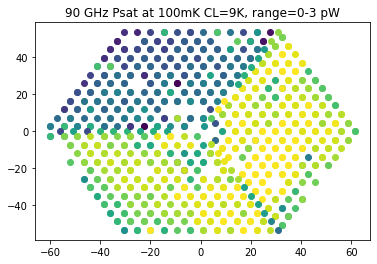

In [45]:
T=9.0
mi=0
ma=3e-12
for key in pixel_info.keys():
    if pixel_info[key]['det'][0]['freq']=='90':
        try:
            scatter(pixel_info[key]['det'][0]['det_x'],pixel_info[key]['det'][0]['det_y'],c=pixel_info[key]['psat'][0],vmin=mi,vmax=ma)
        except:
            pass
title("90 GHz Psat at 100mK CL=9K, range=0-3 pW")

Text(0.5, 1.0, '150 GHz Psat at 100mK CL=9K, range=0-6 pW')

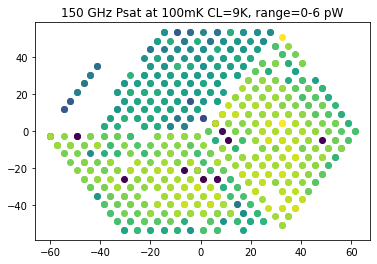

In [46]:
T=9.0
mi=0
ma=6e-12
for key in pixel_info.keys():
    if pixel_info[key]['det'][0]['freq']=='150':
        try:
            scatter(pixel_info[key]['det'][0]['det_x'],pixel_info[key]['det'][0]['det_y'],c=pixel_info[key]['psat'][0],vmin=mi,vmax=ma)
        except:
            pass
title("150 GHz Psat at 100mK CL=9K, range=0-6 pW")

In [ ]:
def assign_freq_index(band, freqlist, dict_thru,highband):
    if (((highband=="S") & (band>3)) | ((highband=="N") & (band<=3))): 
        missing_chip=dict_thru["S"]
    else:missing_chip=dict_thru["N"]
    counts=len(freqlist)
    mux_band=np.zeros(counts)
    mux_index=np.zeros(counts)
    init_band=floor((band%4)*3.5)
    miss=(3.5*66)-counts
    offset=0
    if band%2==1:offset=33
    for i in np.arange(4):
        if (init_band+i) in missing_chip:
            if missing_chip in [3,10]:
                miss-=33; offset+33;
            else: miss-=66; offset+66;
            continue
        start=max(0,66*i-offset)
        end=min(counts,(i+1)*66-offset)
        mux_band[start:end]+=i+init_band
        mux_index[start:end]=np.arange(end-start)
    print("Band %i misses %i resonators (%.2f percent)\n"
          %(band,miss,100*miss/(miss+len(freqlist))))
    return mux_band,mux_index,miss

In [229]:
df_vna[450:530]

,Band,Index,UFM Frequency
450,6.0,55.0,4970.377038
451,6.0,56.0,4971.997200
452,6.0,57.0,4973.037304
453,6.0,58.0,4974.977498
454,6.0,59.0,4977.077708
...,...,...,...
525,0.0,0.0,5293.989399
526,0.0,0.0,5296.049605
527,0.0,0.0,5297.949795
528,0.0,0.0,5299.709971


In [ ]:
def smurf_to_mux(vna_map,smurf_map,design_file="metadata/umux_32_map.pkl",threshold=0.1):
    vna2pad=vna_freq_to_muxpad(vna_map,design_file)
    smurf2mux=smurf_to_mux(S_smurf2freq,S_vna2pad,threshold=0.1)


array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  8.,  9., 10., 11., 12., 13.,
        7.])

Populating the interactive namespace from numpy and matplotlib


In [42]:
def get_psat(data_dict, band, chan, unit = 1e-12, level = 0.9, greedy = False):
    '''Returns the conventional P_sat from a SMuRF IV curve dictionary.

    Parameters
    ----------
    data_dict : dict
        The dictionary containing the IV curve data
    band : int
        The smurf band to extract from the dict
    chan : int
        The channel to extract from the band
    unit: float
        The conversion to SI units, by default 1e-12
    level : float
        The definition of P_sat, i.e. power when R = level*R_n
    greedy : bool, optional
        If True, will return -1000 if the R/Rn curve crosses the level more than once, by default False.
        If False, returns the power at the first instance when R/Rn crosses the level.

    Returns
    -------
    float
        The conventional P_sat
    '''
    chan_data = data_dict[band][chan]

    p = chan_data['p_tes']
    rn = chan_data['R']/chan_data['R_n']

    cross_idx = np.where(np.logical_and(rn - level >= 0, np.roll(rn - level, 1) < 0))[0]
    try:
        assert len(cross_idx) == 1
    except AssertionError:
        if greedy: return -1000
        else: cross_idx = cross_idx[:1]

    try:
        cross_idx = cross_idx[0]
    except IndexError:
        #print(f'band {band}, chan {chan} has IndexError, returning 0')
        #print(cross_idx)
        return 0

    try:
        rn2p = interp1d(rn[cross_idx-1:cross_idx+1], p[cross_idx-1:cross_idx+1])
    except ValueError:
        #print(f'band {band}, chan {chan} has ValueError, returning 0')
        return 0

    return unit*rn2p(level)

In [43]:
def read_psat(ivlist_file,mapfile=None,make_plot=False):

    df_ivlist=pd.read_csv(ivlist_file)

    assert (df_ivlist.columns==['cold_load_temp','bias_line','band','data_path']).all()
    assert np.array(df_ivlist.duplicated(subset=['cold_load_temp','bias_line','band'])).any()==False,"Duplicated Entry!"
    T=np.array(df_ivlist['cold_load_temp'])
    psat_dict={}
    
    if isinstance(mapfile, pd.DataFrame):
        map_data=mapfile
    else:map_data=pd.read_csv(mapfile)

    for index, row in df_ivlist.iterrows():
        #fn = row['data_path']
        #searcher = re.search('/(.+)_iv_raw_data.npy', fn)
        #md_fbase = searcher.groups()[0][-10:]
        #ivfile = md_fbase + '_iv.npy'
        ivfile=row['data_path']
        iv = np.load(ivfile, allow_pickle=True).item()

        if row['band'] !='all':
            print('Reading band ',int(row['band']),' in ',ivfile)
            band_list=[int(row['band'])]
        else:
            band_list=[b for b in iv.keys() if type(b) == np.int64]

        for band in band_list:
            for chan in iv[band].keys():
                if (band,int(chan)) not in psat_dict.keys():
                    psat_dict[(band,int(chan))]={'BL':row['bias_line'],'T':[],'psat':[]}
                try:
                    if (row['bias_line'] !='all'):
                        map_BL=int(map_data.loc[(map_data["smurf_band"]==band) & (map_data["smurf_chan"]==chan)]["biasline"])
                        assert map_BL==row["bias_line"]
                    ch_psat=np.float(get_psat(iv,band,chan, level = 0.9, greedy = False))
                    psat_dict[(band,int(chan))]['T'].append(float(row['cold_load_temp']))
                    psat_dict[(band,int(chan))]['psat'].append(ch_psat)
                except:
                    pass

    if make_plot==True:
        for key in psat_dict.keys():
            plot(psat_dict[key]['T'],psat_dict[key]['psat'])
        plt.xlabel('Temp(K)')
        plt.ylabel('Psat(W)')

    return psat_dict


In [19]:
pd.read_csv("test2.csv")

,smurf_band,smurf_chan,smurf_freq,vna_freq,design_freq,index,mux_band,pad,mux_posn,biasline,pol,freq,det_row,det_col,rhomb,opt,det_x,det_y
0,0.0,389.0,4023.122,4023.122312,4020.870714,1.0,0.0,3.0,5.0,4.0,B,90,1.0,7.0,B,0.0,24.259956,27.539608
1,0.0,69.0,4024.978,4024.982498,4022.741429,2.0,0.0,7.0,5.0,4.0,B,90,1.0,5.0,B,0.0,18.959956,18.359739
2,0.0,197.0,4026.936,4026.962696,4024.612143,3.0,0.0,11.0,5.0,4.0,B,90,1.0,3.0,B,0.0,13.659956,9.179869
3,0.0,37.0,4028.882,4028.882888,4026.482857,4.0,0.0,15.0,5.0,4.0,B,90,1.0,1.0,B,0.0,8.359956,0.000000
4,0.0,293.0,4030.814,4030.763076,4028.353571,5.0,0.0,19.0,5.0,4.0,A,90,0.0,11.0,B,0.0,32.209956,50.489281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1604,7.0,326.0,7985.846,7985.878588,5956.680714,52.0,13.0,10.0,17.0,11.0,B,150,6.0,0.0,C,0.0,-33.329978,-2.650000
1605,7.0,38.0,7989.498,7989.518952,5960.422143,54.0,13.0,18.0,17.0,11.0,B,150,2.0,0.0,C,0.0,-12.129978,-2.650000
1606,7.0,166.0,7992.588,7992.579258,5962.292857,55.0,13.0,22.0,17.0,11.0,B,150,0.0,0.0,C,0.0,-1.529978,-2.650000
1607,7.0,102.0,7994.654,7994.679468,5964.163571,56.0,13.0,26.0,17.0,11.0,B,150,10.0,1.0,C,0.0,-51.879978,-7.239935


Text(0.5, 1.0, '90 GHz Psat at 100mK CL=9K, range=0-3 pW')

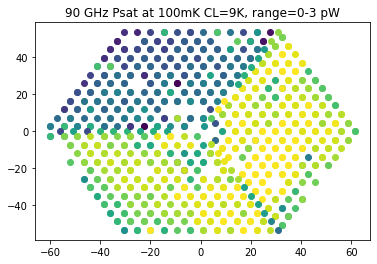